In [1]:
import sys
import numpy as np
import pandas as pd
import scipy.linalg as la
import matplotlib
import seaborn as sns
from pca_cca import util, twoDcca
from sklearn import preprocessing
from pandas_plink import read_plink

In [6]:
def progressBar(bar_length, value, total):
    '''
    Prints a simple progress bar denoting progress in a for loop
    '''

    frac = value/(total)
    prog = '+' * int(round(frac * bar_length))
    space = ' ' * (bar_length - len(prog))

    sys.stdout.write('\rProgress: [{0}] {1:2.2f}%'.format('+' + prog + space, frac*100))
    sys.stdout.flush()

def OMat(x, p):
    y = np.random.randn(x, p)
    return la.qr(y,  mode='economic')[0]

def normalize(M, A):
    (U, D, V) = la.svd(M.T@A@M)
    return M@U@np.diag(D**(-1/2))@V

def towDcca_transform(X, L, R):
    (_, k1) = L.shape
    (_, k2) = R.shape
    return (np.matmul(np.matmul(L.T, X), R)).reshape(-1, k1*k2)

def SVRG(u, v, X, Y, rx, M, m, eta):
    (n, _) = X.shape
    for j in range(M):
        w = u.copy()
        batch_grad = X.T@(X@u-Y@v)/n+rx*u
        for t in range(m):
            i = np.random.choice(n, 1)[0]
            grad = (X[i, :].dot(w-u))*X[i:i+1, :].T + rx*(w-u) + batch_grad
            w -= eta*grad
        u = w.copy()
    return u

def oneDcca_oneStep_SVRG(u0, v0, X, Y, M, m, eta, x_regular=1e-4, y_regular=1e-4):
    (n, p) = X.shape
    (_, q) = Y.shape

    Sxx = np.matmul(X.T, X)/n+x_regular*np.eye(p)
    Syy = np.matmul(Y.T, Y)/n+y_regular*np.eye(q)
    
    u = SVRG(u0, v0, X, Y, x_regular, M, m, eta)
    u /= la.norm(u)
#     u = normalize(u, Sxx)
#     u /= np.sqrt(u.T@Sxx@u)
    
    v = SVRG(v0, u, Y, X, y_regular, M, m, eta)
    v /= la.norm(v)
#     v = normalize(v, Syy)
#     v /= np.sqrt(v.T@Syy@v)
    
    du = la.norm(u-u0,ord='fro')
    dv = la.norm(v-v0,ord='fro')
    
    return u, v, du, dv

def initialization(X):
    (N, m, n) = X.shape
    L, R  = [np.random.randn(l, 1) for l in [m, n]]
#     Var = ((L.T@X@R)**2).sum()/N
#     return L/(Var**0.5), R/(Var**0.5)
    return L/la.norm(L), R/la.norm(R)

def proj(X, L, R):
    (N, m, n) = X.shape
    t = (L.T@X@R).reshape(-1,1)
    P = (np.eye(N)-t@t.T/(t.T@t))
    return (P@X.transpose(1,0,2)).transpose(1,0,2)

def twoDcca_iter_onestep(X, Y, Lx, Rx, Ly, Ry, M, m, eta, x_regular, y_regular):
    XR = np.matmul(X, Rx)[:,:,0]
    YR = np.matmul(Y, Ry)[:,:,0]
    (Lx, Ly, dLx, dLy) = oneDcca_oneStep_SVRG(Lx, Ly, XR, YR, M, m, eta, x_regular, y_regular)
        
    XL = np.matmul(X.transpose(0,2,1), Lx)[:,:,0]
    YL = np.matmul(Y.transpose(0,2,1), Ly)[:,:,0]
    (Rx, Ry, dRx, dRy) = oneDcca_oneStep_SVRG(Rx, Ry, XL, YL, M, m, eta, x_regular, y_regular)

    X_tf = towDcca_transform(X, Lx, Rx)
    Y_tf = towDcca_transform(Y, Ly, Ry)

    return (Lx, Rx, Ly, Ry), la.norm(X_tf - Y_tf , ord='fro'), dLx+dLy+dRx+dRy
    
def twoDcca_iter(X, Y, M, m, eta, x_regular=1e-4, y_regular=1e-4, iter_max=10):
    (_, mx, nx) = X.shape
    (_, my, ny) = Y.shape
    
    (Lx1,Rx1) = initialization(X)
    (Lx2,Rx2) = initialization(X)
    (Ly1,Ry1) = initialization(Y)
    (Ly2,Ry2) = initialization(Y)
    
    residual = np.zeros(iter_max+1)
    error = np.zeros(iter_max+1)
    
    progressBar(40, 0, iter_max)
    
    (Lx1, Rx1, Ly1, Ry1), l1, e1 = twoDcca_iter_onestep(X, Y, Lx1, Rx1, Ly1, Ry1, M, m, eta, x_regular, y_regular)
    
    X_res = proj(X, Lx1, Rx1)
    Y_res = proj(Y, Ly1, Ry1)
    
    (Lx2, Rx2, Ly2, Ry2), l2, e2 = twoDcca_iter_onestep(X_res, Y_res, Lx2, Rx2, Ly2, Ry2, M, m, eta, x_regular, y_regular)
    
    residual[0] = l1 + l2
    error[0] = e1 + e2
    
    for n in range(iter_max):
        progressBar(40, n+1, iter_max)
        X_res = proj(X, Lx2, Rx2)
        Y_res = proj(Y, Ly2, Ry2)
        (Lx1, Rx1, Ly1, Ry1), l1, e1 = twoDcca_iter_onestep(X_res, Y_res, Lx1, Rx1, Ly1, Ry1, M, m, eta, x_regular, y_regular)
    
        X_res = proj(X, Lx1, Rx1)
        Y_res = proj(Y, Ly1, Ry1)

        (Lx2, Rx2, Ly2, Ry2), l2, e2 = twoDcca_iter_onestep(X_res, Y_res, Lx2, Rx2, Ly2, Ry2, M, m, eta, x_regular, y_regular)

        residual[0] = l1 + l2
        error[0] = e1 + e2
        
    return (Lx1, Rx1, Ly1, Ry1), (Lx2, Rx2, Ly2, Ry2), residual, error

In [2]:
exp_mat = pd.read_csv('expression_corrected.tsv', sep='\t', index_col=0)
sample_info = pd.read_csv('sample_info.txt', sep='\t', index_col=0)
(bim, fam, G) = read_plink('genotype/genotype_snps')

Mapping files: 100%|██████████| 3/3 [00:01<00:00,  1.23it/s]


In [3]:
common_inds = sample_info.index.intersection(exp_mat.index)

index = fam[fam["iid"].isin(common_inds)]["i"].values

sample_info = sample_info.loc[common_inds]
exp_mat = exp_mat.loc[common_inds].values
geno_mat = G[:-1, index].compute().T
# geno_mat = G[:40000, index].compute().T

geno_mat = preprocessing.scale(geno_mat)
exp_mat = preprocessing.scale(exp_mat)

geno_mat = geno_mat.reshape(len(index),1014,-1)
# geno_mat = geno_mat.reshape(len(index),200,-1)
exp_mat = exp_mat.reshape(len(index),361,-1)


geno_mat -= geno_mat.mean(axis=0)
exp_mat -= exp_mat.mean(axis=0)

In [4]:
geno_mat.shape

(318, 1014, 728)

In [5]:
exp_mat.shape

(318, 361, 39)

Progress: [+++++++++++++++++++++++++++++++++++++++++] 100.00%

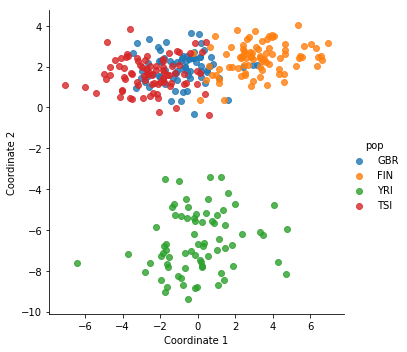

In [7]:
loading1, loading2, residual, error = twoDcca_iter(exp_mat, geno_mat, M=50, m=1000, eta=0.0001, x_regular=.1, y_regular=1, iter_max=300)
sample_info['Coordinate 1'] = towDcca_transform(exp_mat, *(loading1[:2])).flatten()
sample_info['Coordinate 2'] = towDcca_transform(exp_mat, *(loading2[:2])).flatten()
plot_pop = sns.lmplot(
    'Coordinate 1', 'Coordinate 2', hue='pop', data=sample_info, fit_reg=False)
plot_pop.savefig('cca_iter1.png')

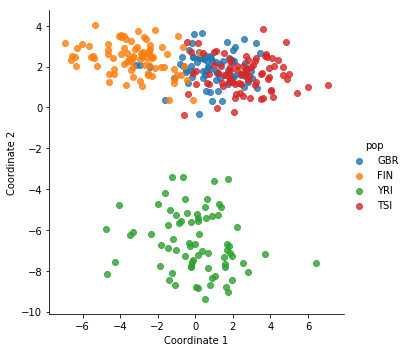

In [8]:
sample_info['Coordinate 1'] = -towDcca_transform(exp_mat, *(loading1[:2])).flatten()
sample_info['Coordinate 2'] = towDcca_transform(exp_mat, *(loading2[:2])).flatten()
plot_pop = sns.lmplot(
    'Coordinate 1', 'Coordinate 2', hue='pop', data=sample_info, fit_reg=False)
plot_pop.savefig('cca_iter1.png')